In [37]:
# MNIST GTSRB CIFAR10
mode = "CIFAR10"

In [38]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.autograd import Variable
from torchvision.utils import save_image
import torch.nn.functional as F
from PIL import Image
import pandas as pd
import cv2
# import matplotlib as plt
from matplotlib import pyplot as plt
from collections import Counter

import databackdoor.gtsrbData as gtsrbData
import databackdoor.mnistData as mnistData
import databackdoor.cifar10Data as cifar10Data
import databackdoor.cifar100Data as cifar100Data


# ===========================================================================


global maxList
maxList = []

def get_max(model, input, output):
    A = output[0].cpu().detach().numpy()
    maxList.append(np.argmax(A))

def pre_get_max(model, input):
    A = input[0].cpu().detach().numpy()
    maxList.append(np.argmax(A))

def get_max_cov(model, input, output):
    A = output[0].cpu().detach().numpy()
    maxList.append(np.max(A))

def pre_get_max_cov(model, input):
    A = input[0].cpu().detach().numpy()
    maxList.append(np.max(A))


global activationData

activationData = []

def activation_data_cov(model, input, output):
    print("+++++++++++++++++++++++++++++++")

    A = output[0].cpu().detach().numpy()
    A = A.ravel()

    activationData.append(A)

def pre_activation_data_cov(model, input):
    print("+++++++++++++++++++++++++++++++A")

    A = input[0].cpu().detach().numpy()
    A = A.ravel()

    activationData.append(A)

def activation_data(model, input, output):
    print("+++++++++++++++++++++++++++++++")

    A = output[0].cpu().detach().numpy()

    plt.title("The activation")
    plt.xlabel("index")
    plt.ylabel("value")
    X, = plt.plot(A)
    plt.legend([X], ["Activation"])
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.show()

def pre_activation_data(model, input):
    print("+++++++++++++++++++++++++++++++")

    A = input[0].cpu().detach().numpy()

    plt.title("The activation")
    plt.xlabel("index")
    plt.ylabel("value")
    X, = plt.plot(A)
    plt.legend([X], ["Activation"])
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.show()


def show_image():
    plt.figure(figsize=(20, 10))
    plt.figure(1)

    ax1 = plt.subplot(211)
    ax1.set_title("The argmax(ReLU) of poisoned model")
    ax1.set_xlabel("index")
    ax1.set_ylabel("value")
    X, = ax1.plot(activationData[0])
    ax1.legend([X], ["Activation"])

    ax2 = plt.subplot(212)
    ax2.set_title("The argmax(ReLU) of clean model")
    ax2.set_xlabel("index")
    ax2.set_ylabel("value")
    Y, = ax2.plot(activationData[1])
    ax2.legend([Y], ["Activation"])

    plt.show()




GTSRBtransform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.3403, 0.3121, 0.3214),
                            (0.2724, 0.2608, 0.2669))
    ])

CIFARtransform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    
# ===========================================================================

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu")

# ===========================================================================


if mode == "MNIST":
    poisonedModel = mnistData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load("./model/MNIST_poisoned.pth"))
    cleanModel = mnistData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load("./model/MNIST_para.pth"))

    noiseData= mnistData.customDataset(annotations="data/noise/MNIST.csv", img_dir="data/noise/MNIST", transform=transforms.ToTensor(), flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= mnistData.customDataset(annotations="data/PoisonedMNIST/label.csv", img_dir="data/PoisonedMNIST/test", transform=transforms.ToTensor(), flag="train")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.conv1[1].register_forward_hook(get_max_cov)
    handle_standard = cleanModel.conv1[1].register_forward_hook(get_max_cov)

elif mode == "GTSRB":
    poisonedModel = gtsrbData.NeuralNetwork().to(device)
    poisonedModel.load_state_dict(torch.load("./model/GTSRB_poisoned.pth"))
    cleanModel = gtsrbData.NeuralNetwork().to(device)
    cleanModel.load_state_dict(torch.load("./model/GTSRB_para.pth"))

    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=GTSRBtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.GTSRB(root="data/", split="test", transform=GTSRBtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedGTSRB/testlabel.csv", img_dir="data/PoisonedGTSRB/test", transform=GTSRBtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)

    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()


    handle = poisonedModel.localization[5].register_forward_hook(get_max_cov)
    handle_standard = cleanModel.localization[5].register_forward_hook(get_max_cov)

elif mode == "CIFAR10":
    # poisonedModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    poisonedModel = cifar10Data.ResNet18().to(device)
    poisonedModel.load_state_dict(torch.load("./model/CIFAR10_poisoned.pth"))
    # cleanModel = cifar10Data.ResNet(cifar10Data.BasicBlock, [2, 2, 2, 2]).to(device)
    cleanModel = cifar10Data.ResNet18().to(device)
    cleanModel.load_state_dict(torch.load("./model/CIFAR10_para.pth"))

    # same size with GTSRB
    noiseData= gtsrbData.customDataset(annotations="data/noise/GTSRB.csv", img_dir="data/noise/GTSRB", transform=CIFARtransform, flag="test")
    NoiseData = DataLoader(dataset=noiseData, batch_size=1, shuffle=True)

    test_dataset = datasets.CIFAR10(root="data/", train=False, transform=CIFARtransform, download=True)
    cleanData = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    testData= gtsrbData.customDataset(annotations="data/PoisonedCIFAR10/testlabel.csv", img_dir="data/PoisonedCIFAR10/test", transform=CIFARtransform, flag="test")
    poisonedData = DataLoader(dataset=testData, batch_size=1, shuffle=True)
    
    torch.no_grad()
    poisonedModel.eval()
    cleanModel.eval()

    handle = poisonedModel.layer1.register_forward_pre_hook(pre_get_max_cov)
    handle_standard = cleanModel.layer1.register_forward_pre_hook(pre_get_max_cov)





Files already downloaded and verified


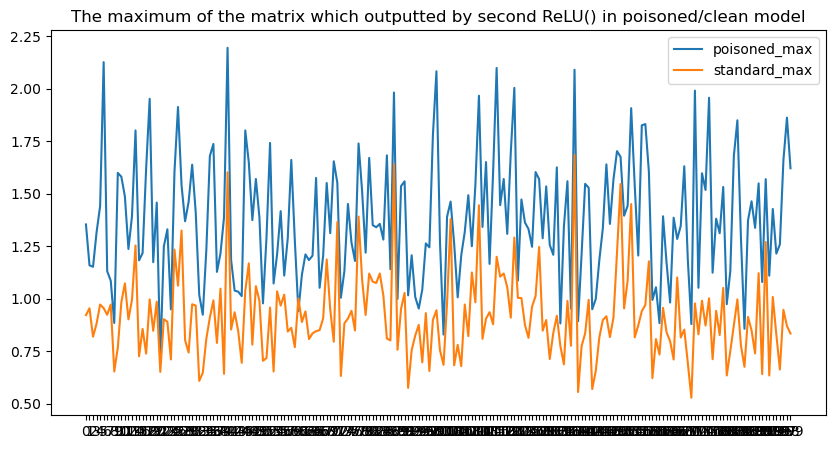

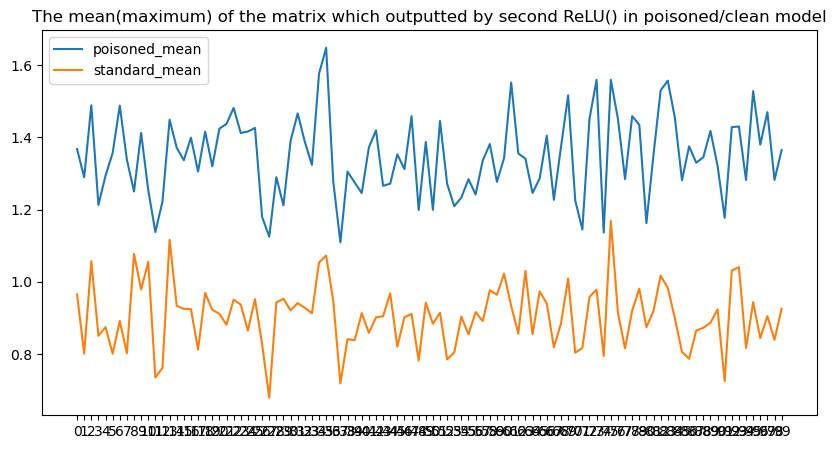

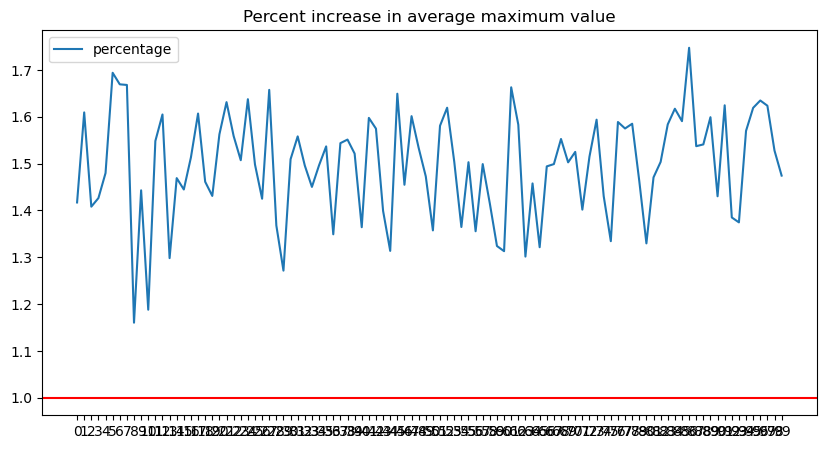

[3.2481103, 2.265173, 3.7691283, 1.9862161, 3.5403435, 2.0784185, 3.728758, 2.3226216, 3.414538, 2.1062782, 3.4972682, 2.1109345, 3.3391306, 2.0523086, 3.2620385, 2.0047052, 3.324642, 2.3288476, 3.8396356, 1.9600412, 3.4454954, 2.079625, 3.7491605, 2.2142148, 3.504117, 2.0790448, 3.556034, 2.1467056, 3.1470265, 2.156696, 3.614147, 2.0624015, 3.385861, 2.3402119, 3.6015017, 2.0719666, 3.7407885, 2.1614943, 3.1718206, 1.9388025, 3.6452334, 2.1310432, 3.2651594, 2.3328686, 3.2930925, 2.4222136, 3.8682892, 2.0824308, 4.0932503, 2.4162586, 3.8489506, 2.3019998, 3.3605607, 2.303775, 3.3968155, 2.1483197, 4.187582, 2.271365, 3.311444, 2.0483775, 3.995046, 2.0066912, 3.1115477, 2.0707471, 3.3726528, 2.082032, 3.3381581, 2.1636062, 3.4065208, 2.2479796, 3.8734553, 2.083788, 3.526103, 2.2224424, 3.4612231, 2.4911835, 3.5143988, 1.8027906, 3.183954, 2.352563, 3.1336257, 2.0960584, 3.167584, 2.191033, 3.9710965, 2.2936714, 3.5673678, 2.2018774, 3.9383948, 2.4040792, 3.2119465, 1.9234515, 3.3147192

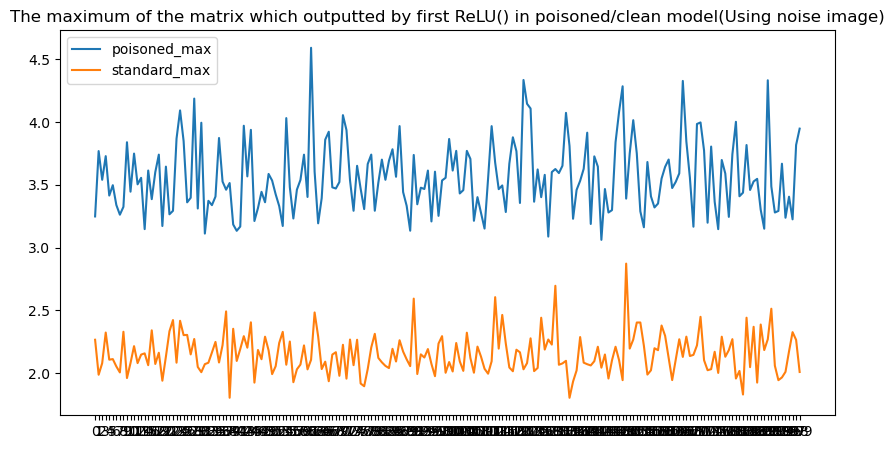

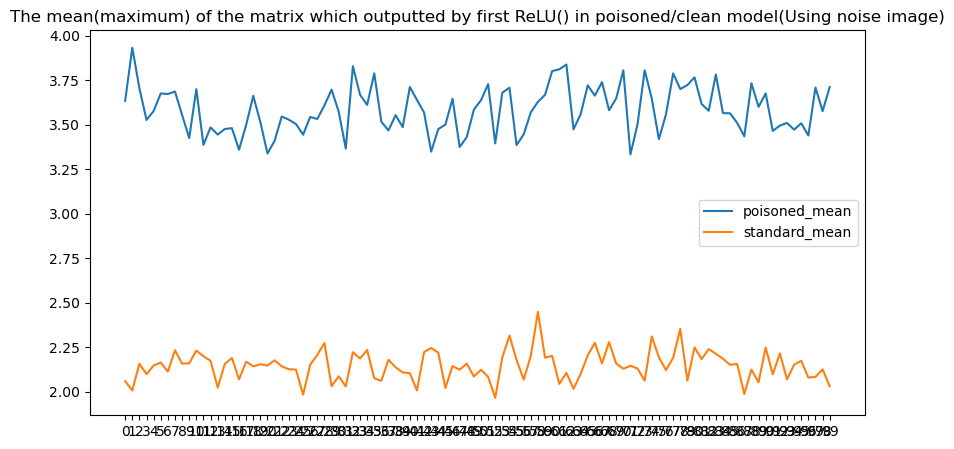

<BarContainer object of 1 artists>

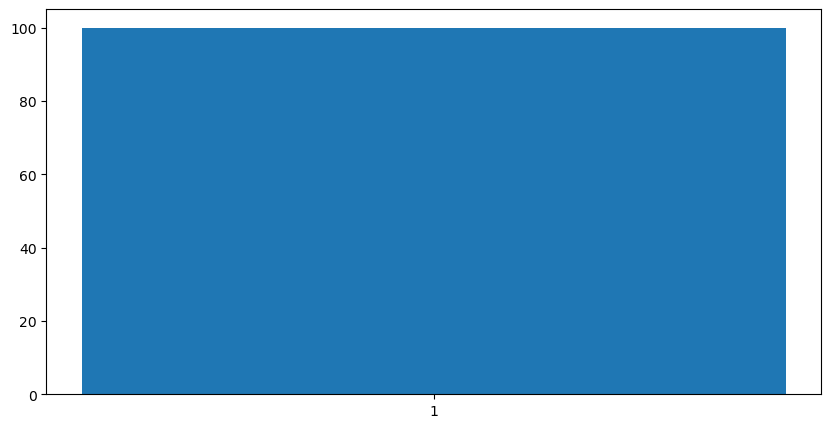

In [40]:
maxList = []
x = 0

for i, y in cleanData:
    x += 1
    i = i.to(device)
    output = poisonedModel(i)
    output_standard = cleanModel(i)
    if x >= 200:
        break

label = np.arange(len(maxList)/2)
poisoned_max = []
standard_max = []
for a in range(len(maxList)):
    if a % 2 == 0:
        poisoned_max.append(maxList[a])
    else:
        standard_max.append(maxList[a])


plt.plot(label, poisoned_max, label="poisoned_max")
plt.plot(label, standard_max, label="standard_max")

plt.title("The maximum of the matrix which outputted by second ReLU() in poisoned/clean model")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()


#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

number_of_means = 100

poisoned_mean = []
standard_mean = []
for j in range(number_of_means):
    maxList = []
    x = 0
    for i, y in cleanData:
        x += 1
        i = i.to(device)
        output = poisonedModel(i)
        output_standard = cleanModel(i)
        if x >= 5:
            break
    label = np.arange(number_of_means)
    poisoned_max = []
    standard_max = []
    for a in range(len(maxList)):
        if a % 2 == 0:
            poisoned_max.append(maxList[a])
        else:
            standard_max.append(maxList[a])
    
    poisoned_mean.append(np.mean(poisoned_max))
    standard_mean.append(np.mean(standard_max))
    
# =====================================================================
# handle.remove()
# handle_standard.remove()
# =====================================================================


plt.plot(label, poisoned_mean, label="poisoned_mean")
plt.plot(label, standard_mean, label="standard_mean")


plt.title("The mean(maximum) of the matrix which outputted by second ReLU() in poisoned/clean model")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

percentage = []

for i in range(len(poisoned_mean)):
    percentage.append(poisoned_mean[i]/standard_mean[i])

plt.plot(label, percentage, label="percentage")
plt.axhline(y=1, color='r', linestyle='-')
plt.title("Percent increase in average maximum value")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()



maxList = []

x = 0

for i, y in NoiseData:
    x += 1
    i = i.to(device)
    output = poisonedModel(i)
    output_standard = cleanModel(i)
    if x >= 200:
        break

print(maxList)

label = np.arange(len(maxList)/2)
poisoned_max = []
standard_max = []
for a in range(len(maxList)):
    if a % 2 == 0:
        poisoned_max.append(maxList[a])
    else:
        standard_max.append(maxList[a])



plt.plot(label, poisoned_max, label="poisoned_max")
plt.plot(label, standard_max, label="standard_max")

plt.title("The maximum of the matrix which outputted by first ReLU() in poisoned/clean model(Using noise image)")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

number_of_means = 100

poisoned_mean = []
standard_mean = []
for j in range(number_of_means):
    maxList = []
    x = 0
    for i, y in NoiseData:
        x += 1
        i = i.to(device)
        output = poisonedModel(i)
        output_standard = cleanModel(i)
        if x >= 5:
            break
    label = np.arange(number_of_means)
    poisoned_max = []
    standard_max = []
    for a in range(len(maxList)):
        if a % 2 == 0:
            poisoned_max.append(maxList[a])
        else:
            standard_max.append(maxList[a])
    
    poisoned_mean.append(np.mean(poisoned_max))
    standard_mean.append(np.mean(standard_max))

handle.remove()
handle_standard.remove()

plt.plot(label, poisoned_mean, label="poisoned_mean")
plt.plot(label, standard_mean, label="standard_mean")


plt.title("The mean(maximum) of the matrix which outputted by first ReLU() in poisoned/clean model(Using noise image)")
plt.xticks(label)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

compare_list = []
for i in range(len(poisoned_mean)):
    if poisoned_mean[i] > standard_mean[i]:
        compare_list.append(1)
    else:
        compare_list.append(0)

stat = Counter(compare_list)

plt.xticks([0, 1])
plt.bar(stat.keys(), stat.values(), width=0.35)

In [41]:
# # GTSRB Noise
# maxList = []

# handle = GTSRBPoisonedModel.localization[5].register_forward_hook(get_max_cov)
# handle_standard = GTSRBCleanModel.localization[5].register_forward_hook(get_max_cov)
# x = 0

# for i, j in GTSRBNoiseData:
#     x += 1
#     i = i.to(device)
#     output = GTSRBPoisonedModel(i)
#     output_standard = GTSRBCleanModel(i)
#     if x >= 200:
#         break

# print(maxList)

# label = np.arange(len(maxList)/2)
# poisoned_max = []
# standard_max = []
# for a in range(len(maxList)):
#     if a % 2 == 0:
#         poisoned_max.append(maxList[a])
#     else:
#         standard_max.append(maxList[a])



# plt.plot(label, poisoned_max, label="poisoned_max")
# plt.plot(label, standard_max, label="standard_max")

# plt.title("The maximum of the matrix which outputted by second ReLU() in poisoned/clean model(Using noise image)")
# plt.xticks(label)
# plt.rcParams["figure.figsize"] = (20, 10)
# plt.legend()
# plt.show()

# number_of_means = 100

# poisoned_mean = []
# standard_mean = []
# for j in range(number_of_means):
#     maxList = []
#     x = 0
#     for i, y in GTSRBNoiseData:
#         x += 1
#         i = i.to(device)
#         output = GTSRBPoisonedModel(i)
#         output_standard = GTSRBCleanModel(i)
#         if x >= 5:
#             break
#     label = np.arange(number_of_means)
#     poisoned_max = []
#     standard_max = []
#     for a in range(len(maxList)):
#         if a % 2 == 0:
#             poisoned_max.append(maxList[a])
#         else:
#             standard_max.append(maxList[a])
    
#     poisoned_mean.append(np.mean(poisoned_max))
#     standard_mean.append(np.mean(standard_max))

# handle.remove()
# handle_standard.remove()

# plt.plot(label, poisoned_mean, label="poisoned_mean")
# plt.plot(label, standard_mean, label="standard_mean")


# plt.title("The mean(maximum) of the matrix which outputted by second ReLU() in poisoned/clean model(Using noise image)")
# plt.xticks(label)
# plt.rcParams["figure.figsize"] = (20, 10)
# plt.legend()
# plt.show()

# percentage = []

# for i in range(len(poisoned_mean)):
#     percentage.append(poisoned_mean[i]/standard_mean[i])

# plt.plot(label, percentage, label="percentage")
# plt.axhline(y=1, color='r', linestyle='-')
# plt.title("Percent increase in average maximum value")
# plt.xticks(label)
# plt.rcParams["figure.figsize"] = (20, 10)
# plt.legend()